In [1]:
include("XYModel.jl")
using .XYModel
include("../../logger/logger.jl")
using .MyLogger
include("../utils.jl")
using .Utils
using Optimisers, Logging, LinearAlgebra, Statistics, StatsBase, ProgressMeter
using CairoMakie

init_logger(dir="../../logs", level=:Info)
println(names(XYModel))

[:XYModel, :calc_correlation_function, :calc_energy, :calc_gradient, :calc_gradient_no_constraints, :calc_helicity_terms, :calc_magnetization, :calc_round_trip_times, :initial_state, :metropolis_sampler]


In [ ]:
N = 20
β_min = 0.5
β_max = 1.5
M = 20
η = 0.001
mcSteps = 2*10^4
eqSteps = 10^2
epochs = 200
batch_size = 10

@info """
Hyperparameters of XY model:
--------------------
system size: $(N*N),
the number of replica: $M,
MCS: $mcSteps
"""
println("Set hyperparameters.")

Set hyperparameters.


In [ ]:
init_β_set = Utils.set_temperatures(
    β_min, 
    β_max; 
    M=M, 
    method=:geometric
)
config = XYModel.initial_state(N)
exchange_prob_means, _ = XYModel.calc_acceptance_and_rtt(N, config, init_β_set)

println(init_β_set)
println(exchange_prob_means)

[0.5, 0.5278428432616464, 0.557236134365078, 0.5882662110627832, 0.6210242188842705, 0.6556063788604328, 0.6921142701563261, 0.730655128442549, 0.7713421608816369, 0.8142948786546912, 0.8596394480049789, 0.9075090608296408, 0.958044325908048, 1.011393681915983, 1.0677138334387952, 1.1271702112642512, 1.189937458307106, 1.2561999425927195, 1.326152298806516, 1.4]
[0.6487458870652149, 0.6261403670069343, 0.6069382509090023, 0.5832910772276187, 0.5501429818219125, 0.5392782124911292, 0.4901037753123698, 0.45407893960695567, 0.4454149611469832, 0.38842853392813576, 0.3549282156780998, 0.3520018168724804, 0.38730030436625057, 0.4175399955783718, 0.44627700599335496, 0.46354143253455676, 0.4840726399725608, 0.5003527883377659, 0.5174803638080636]


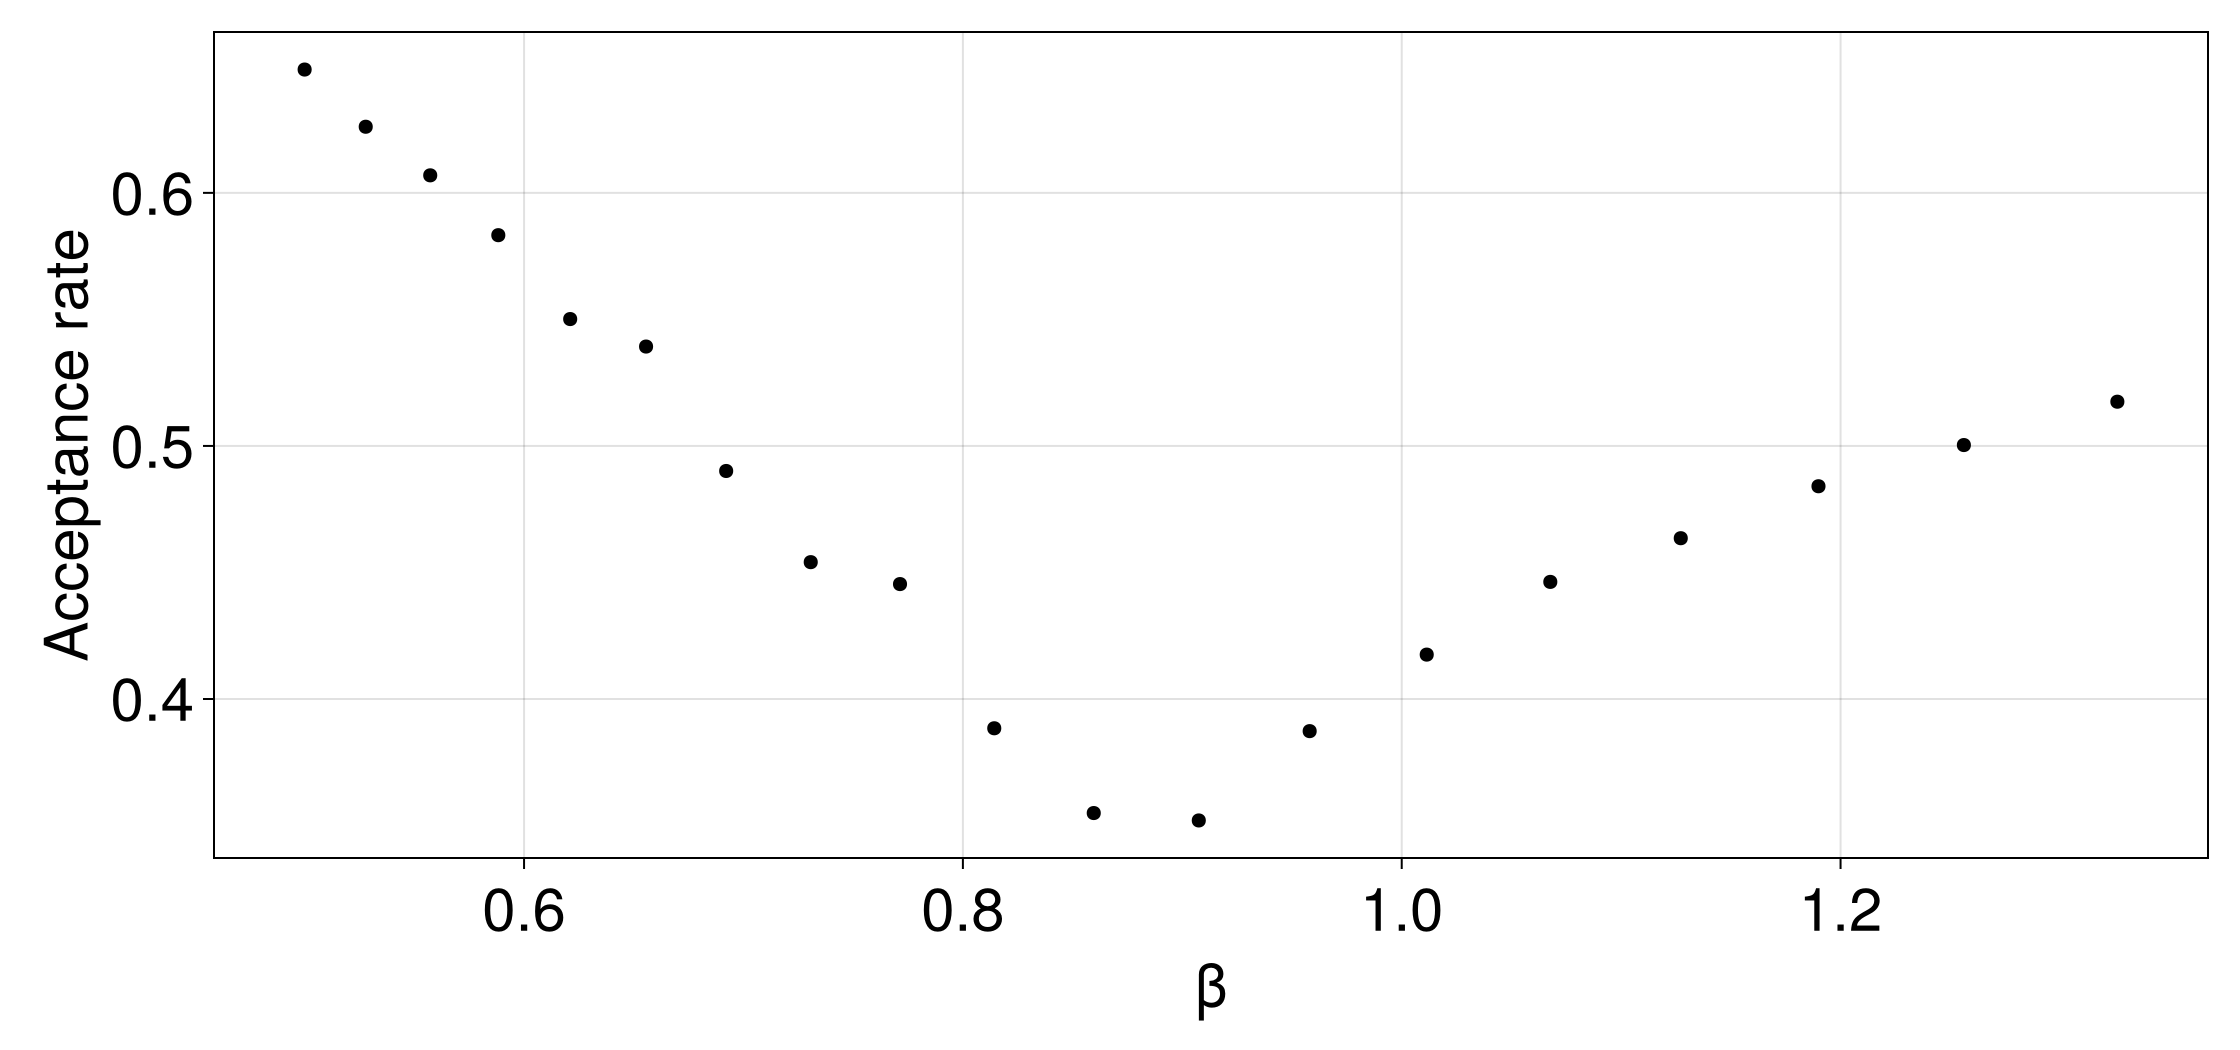

CairoMakie.Screen{IMAGE}


In [ ]:
begin
    fig1 = Figure(size=(1120, 525), fontsize = 30)
    ax1 = fig1[1, 1] = Axis(fig1, xlabel="β", ylabel="Acceptance rate")
    scatter!(ax1, init_β_set[1:(end-1)], exchange_prob_means, color=:black, markersize=10)
    
    display(fig1)
end

In [ ]:
β_set = deepcopy(init_β_set)
β_set_trace = [β_set]
optimizer = Adam(η)
setup = Optimisers.setup(optimizer, β_set)

exchange_prob_trace = [exchange_prob_means]
# init_loss = Statistics.mean((exchange_prob_means .- target).^2)
init_loss = Statistics.var(exchange_prob_means)
loss_trace = [init_loss]

@showprogress for epoch in 1:epochs
    samples = []
    for _ in 1:batch_size
        grad, exchange_prob_means = XYModel.calc_gradient_no_constraints(
            N, 
            β_set;
            mcSteps=mcSteps, 
            eqSteps=eqSteps,
            exchange_interval=1,
            # target=target
        )
        push!(samples, grad)
    end
    # loss_func = Statistics.mean((exchange_prob_means .- target).^2)
    loss_func = Statistics.var(exchange_prob_means)
    grad_mean = Statistics.mean(samples)
    grad_std = Statistics.std(samples)
    grad_mean[1] = 0.0
    grad_mean[end] = 0.0
    setup, β_set = Optimisers.update(setup, β_set, grad_mean)

    push!(β_set_trace, deepcopy(β_set))
    push!(exchange_prob_trace, exchange_prob_means)
    push!(loss_trace, loss_func)

    formatted_grads = [
        "$(round(mean_val, digits=5)) ± $(round(std_val, digits=5))"
        for (mean_val, std_val) in zip(grad_mean, grad_std)
    ]
    grad_str = join(formatted_grads, ", ")

    @info """
    Epoch $epoch: 
    --------------------
    Mean Gradient: [$grad_str], 
    exchange probs: $exchange_prob_means, 
    loss function: $loss_func
    """
end

Progress: 100%|█████████████████████████████████████████| Time: 18:06:51


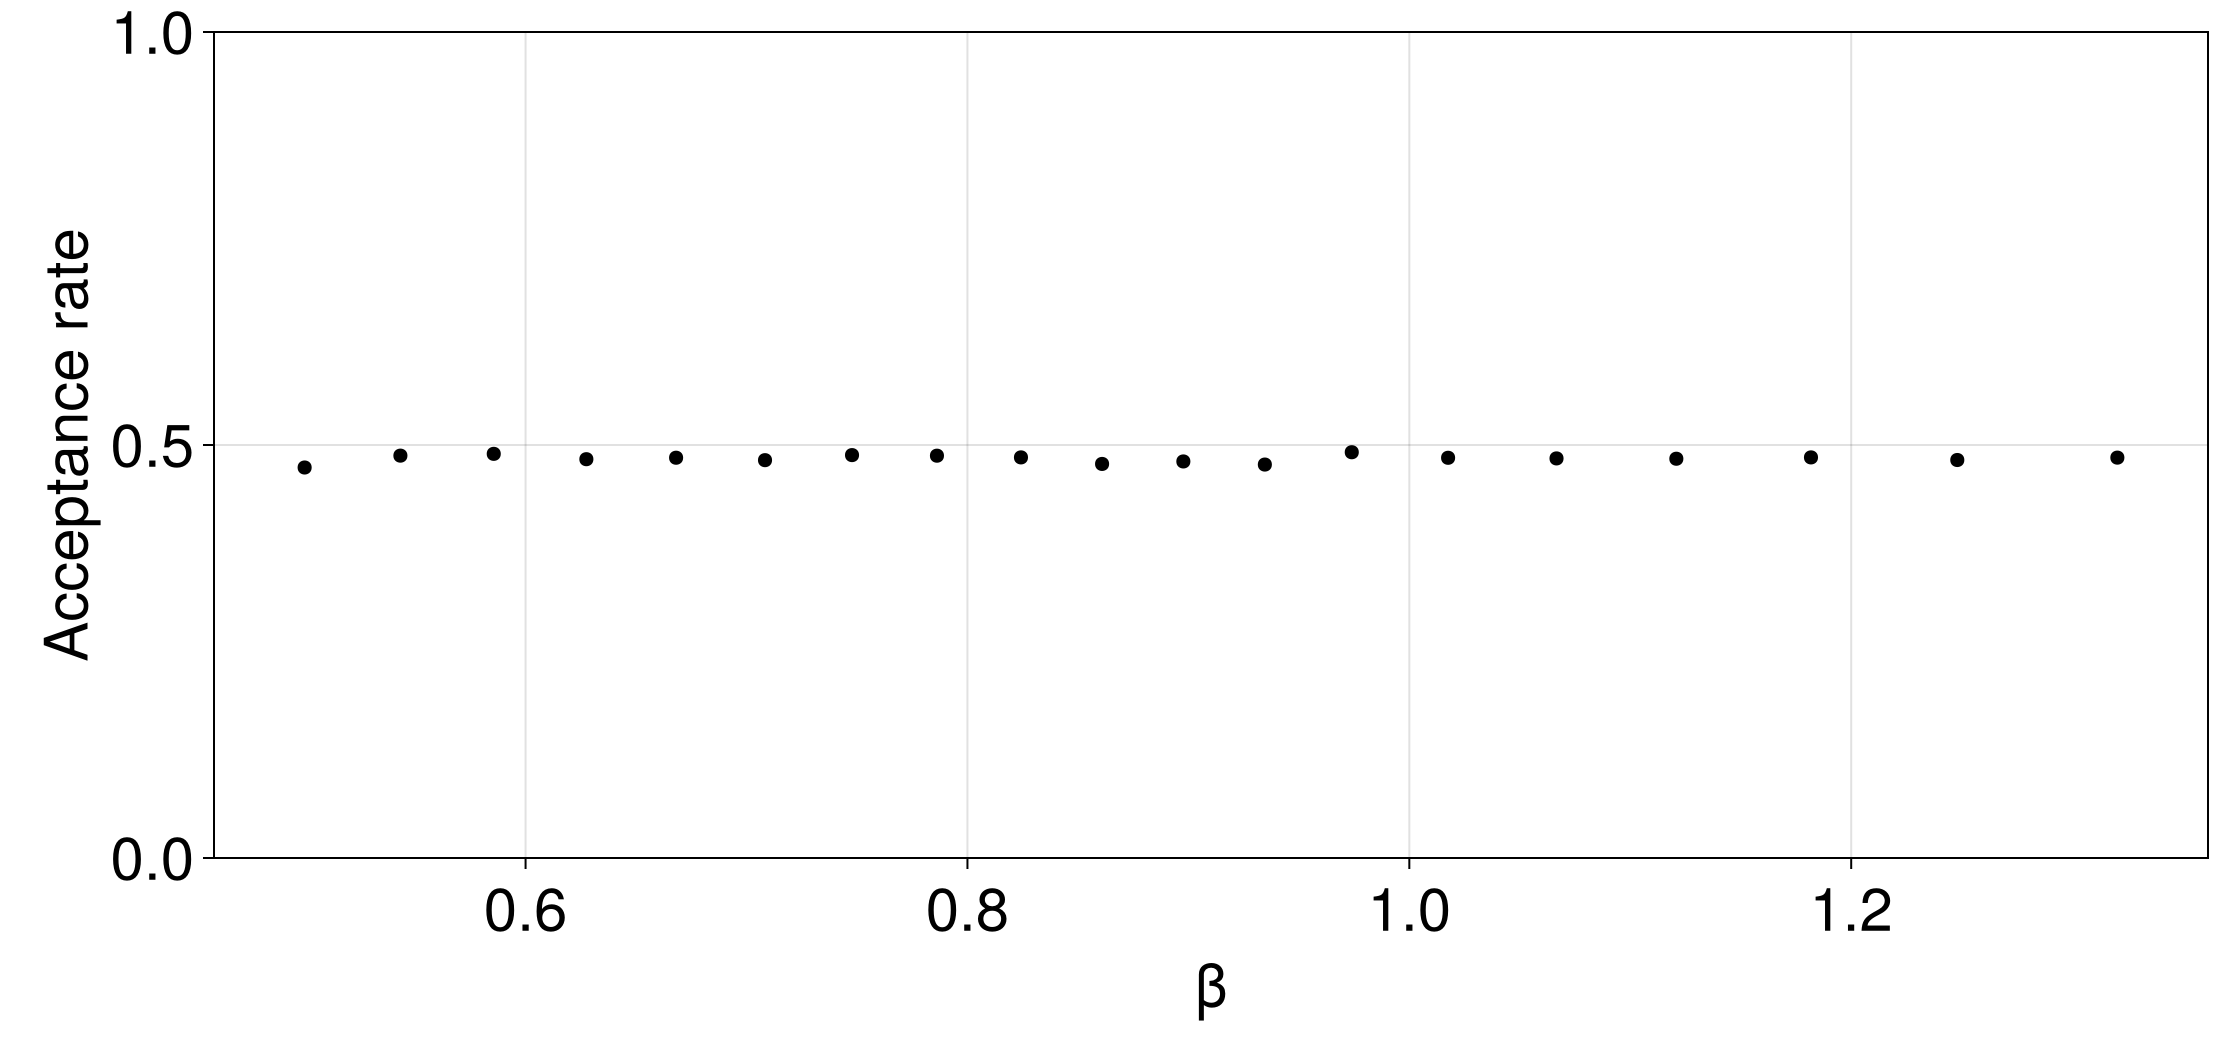

CairoMakie.Screen{IMAGE}


In [ ]:
fig1 = Figure(size=(1120, 525), fontsize = 30)
ax1 = fig1[1, 1] = Axis(fig1, xlabel="β", ylabel="Acceptance rate")
ylims!(ax1, 0, 1)
scatter!(ax1, β_set_trace[end][1:(end-1)], exchange_prob_means, color=:black, markersize=10)

display(fig1)

In [7]:
dir = "../../plots/XY_model/L=$N/M=$M"
if dir !== nothing
    mkpath(dir)
end

"../../plots/XY_model/L=20/M=20"

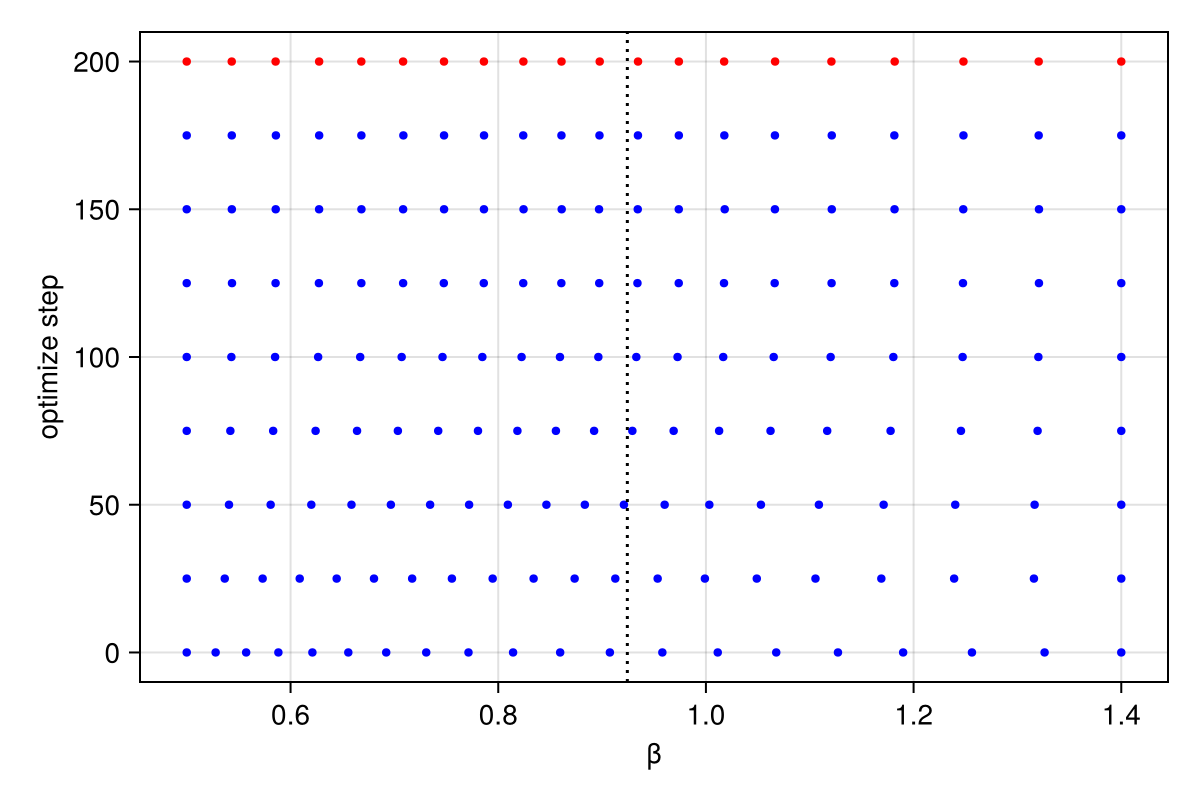

In [ ]:
fig = Figure(font="Computer Modern", size=(600, 400))
ax = Axis(fig[1, 1],
    xlabel = "β",
    ylabel = "optimize step"
)
# xlims!(ax, 0.4, 2.1)
ylims!(ax, -10, epochs+10)

plot_interval = 25
for (i, β_set) in enumerate(β_set_trace)
    step = i - 1
    if step == 0 || step % plot_interval == 0
        y_values = fill(step, length(β_set))
        marker_color = (step == epochs) ? :red : :blue

        scatter!(ax, β_set, y_values,
            color = marker_color,
            markersize = 6,
            strokewidth = 0
        )
    end
end

# β_c = 1.1199
# vlines!(ax, [β_c], color=:black, linestyle=:dot, label="Critical βc")
# text!(
#     ax,
#     L"\beta_c \approx %$(round(β_c, digits=3))", 
#     position = (β_c, -15), 
#     align = (:left, :center), 
#     offset = (5, 0)
# )
β_dash = 0.92432
vlines!(ax, [β_dash], color=:black, linestyle=:dot, label="β at maximum specific heat")

display(fig)
save("$dir/Evolution of the Inverse-Temperature Ladder over Optimization Epochs.png", fig; px_per_unit=4)

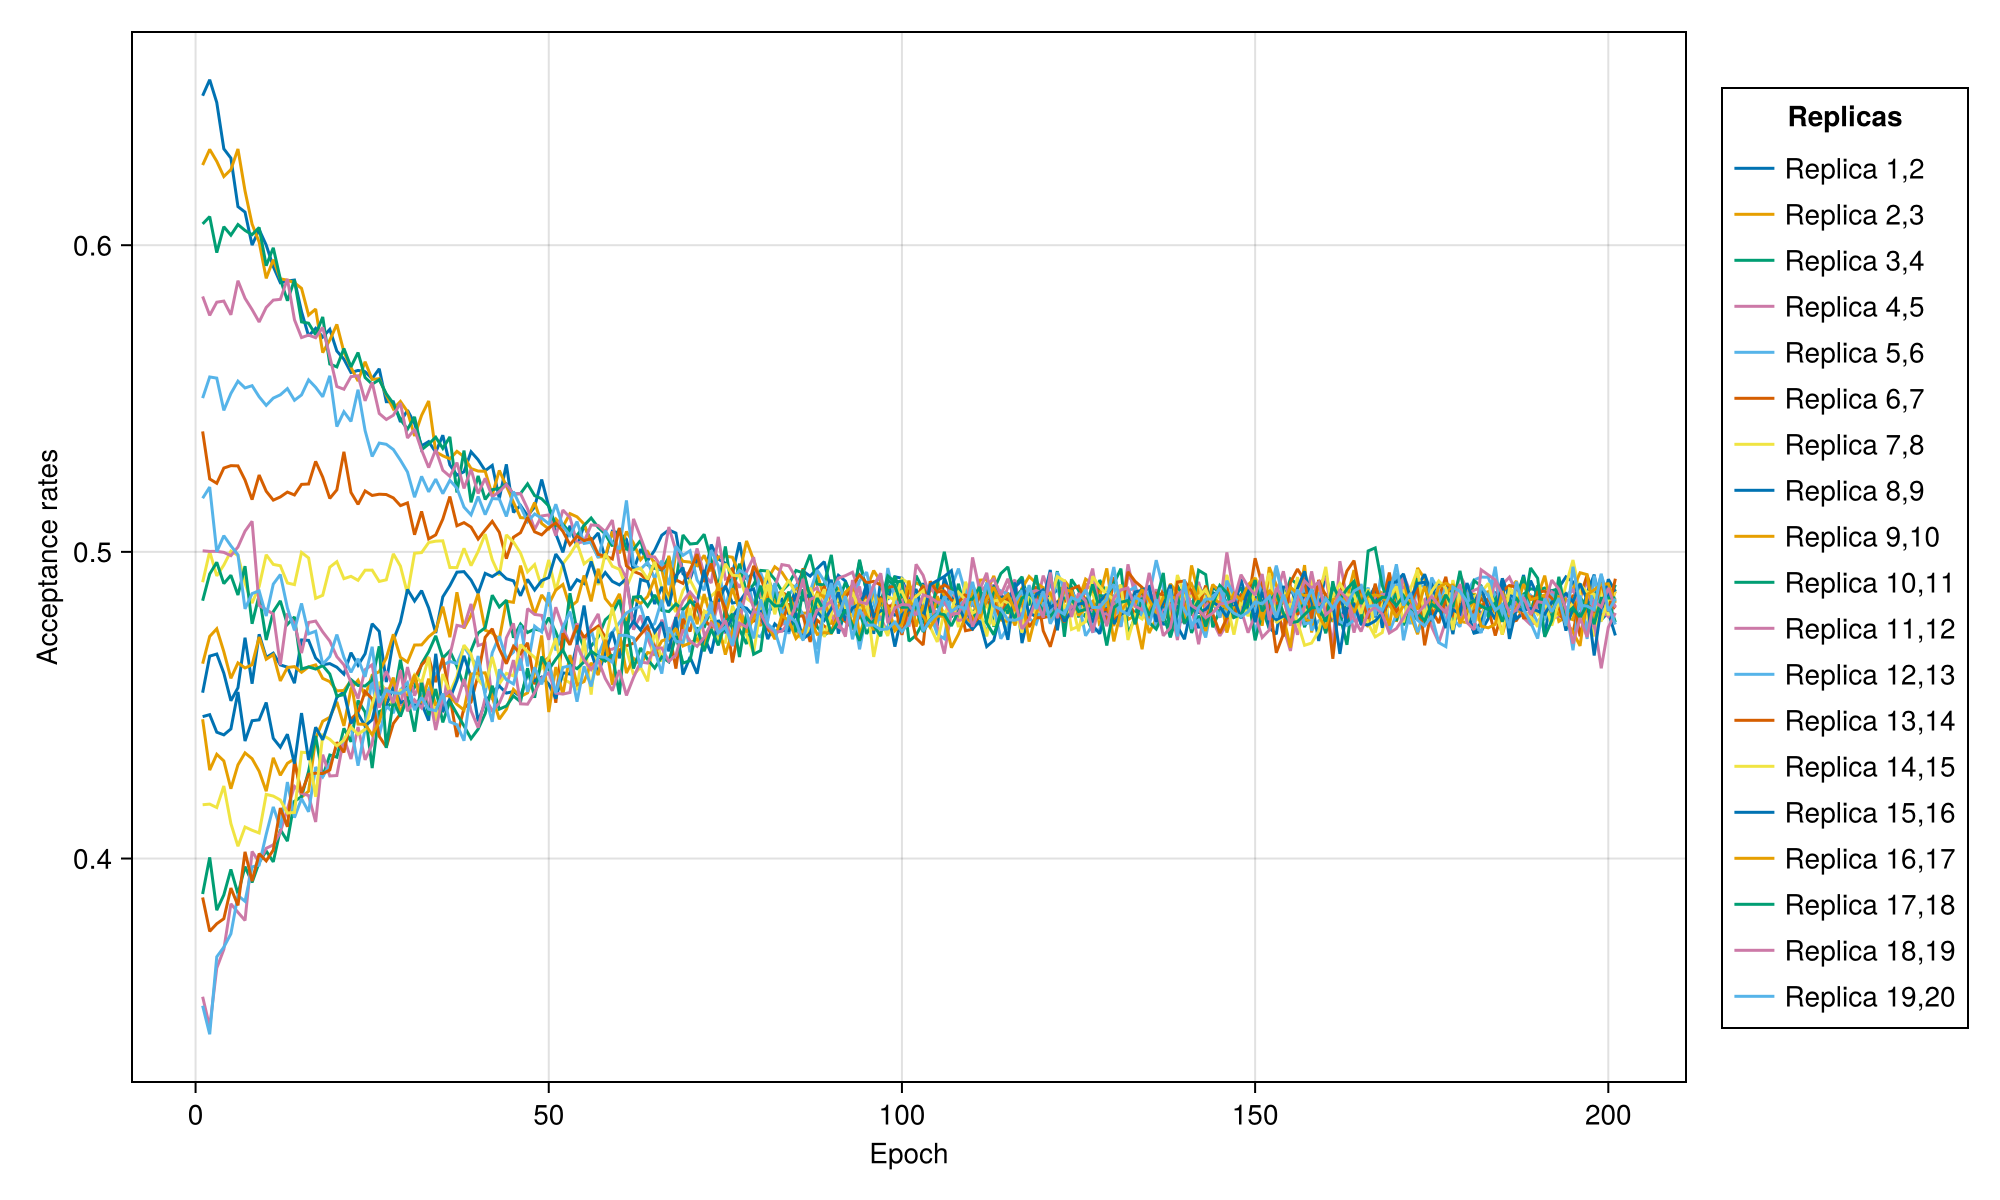

In [9]:
data = hcat(exchange_prob_trace...)
fig2 = Figure(size=(1000, 600))
ax2  = Axis(
    fig2[1, 1], 
    # title = "Replica Exchange Probabilities over Epochs", 
    xlabel = "Epoch", 
    ylabel = "Acceptance rates"
)
for i in 1:(M-1)
    lines!(ax2, 1:(epochs+1), data[i, :], label = "Replica $i,$(i+1)")
end

Legend(fig2[1, 2], ax2, "Replicas")

# axislegend(ax2; position = :rt)
display(fig2)
save("$dir/Replica Exchange Probabilities over Epochs.png", fig2; px_per_unit=4)

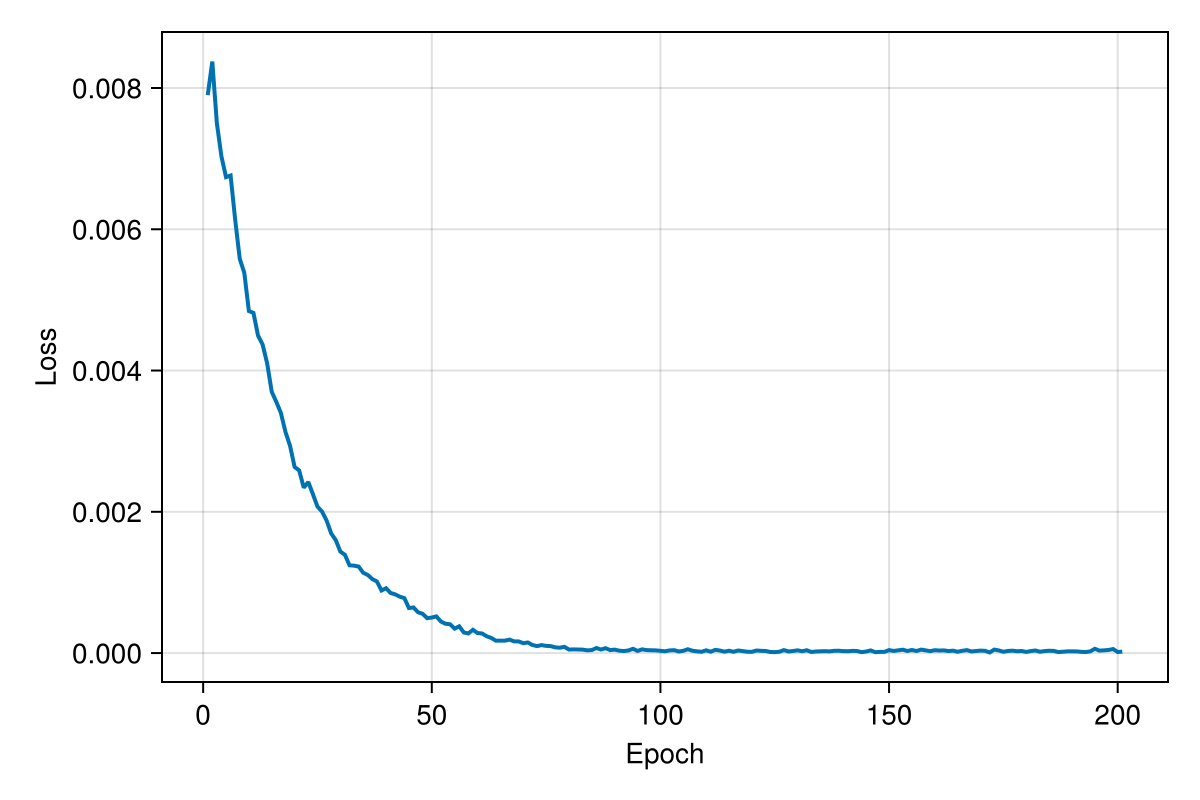

In [10]:
fig3 = Figure(size=(600, 400))
ax3 = Axis(
    fig3[1, 1]; 
    # title = "Loss function", 
    xlabel = "Epoch", 
    ylabel = "Loss"
)
lines!(ax3, 1:(epochs+1), loss_trace; linewidth = 2)
# scatter!(ax3, 1:n, loss_trace; markersize = 4)

display(fig3)
save("$dir/Loss function.png", fig3; px_per_unit=4)

In [ ]:
println(β_set_trace[end])

[0.5, 0.5433438996411224, 0.5855968509828601, 0.6275139972962122, 0.668127860377239, 0.7083779131375098, 0.7477581581927859, 0.7861985278604073, 0.824224114204505, 0.8609374954692215, 0.897723014039203, 0.9346094151287975, 0.9739493095716766, 1.0175524000901681, 1.066623406798717, 1.1208551075230526, 1.1818008003068405, 1.248023025375893, 1.320473287259196, 1.4]
